In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from pathlib import Path
from functools import partial
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import re, os
import random

In [3]:
raw_dir = Path("raw")
    
raws = [raw_path for raw_path in raw_dir.ls() if ".tif" in raw_path.as_posix()]
images = sorted([raw_path for raw_path in raws if "_image" in raw_path.name])
labels = sorted([raw_path for raw_path in raws if "_label" in raw_path.name])

processed_dir = Path("processed")
# for f in processed_dir.ls(): os.remove(f)
    
l=224

In [4]:
from tqdm import tqdm
random.seed(23)
cutoff=1
empty = 0
R_popu = 0 #labelled by nick
dense_popu = 0 #has dense cells
orig_popu = 0 #labelled by Mallar


for image_path,label_path in tqdm(zip(images,labels)):
    image = cv.imread(image_path.as_posix(), cv.COLOR_BGR2GRAY)
    label = cv.imread(label_path.as_posix(), cv.COLOR_BGR2GRAY)

    if image.shape != label.shape:
        raise ValueError(image_path.as_posix() + label_path.as_posix())
    i_max = image.shape[0]//l
    j_max = image.shape[1]//l

# If the cells were labelled as 255, or something else mistakenly, instead of 1.
    label[label!=0]=1

    for i in range(i_max):
        for j in range(j_max):
            cropped_image = image[l*i:l*(i+1), l*j:l*(j+1)]
            cropped_label = label[l*i:l*(i+1), l*j:l*(j+1)]
            
            if "441.1_Z0063_R" in image_path.as_posix():
                dense_popu+=1
                cropped_image_path = processed_dir/(image_path.stem + "_i" + str(i) + "_j" + str(j) + image_path.suffix)
                cropped_label_path = processed_dir/(label_path.stem + "_i" + str(i) + "_j" + str(j) + label_path.suffix)
            elif ("_R_" in image_path.as_posix() and (cropped_label!=0).any()):
                R_popu+=1
                cropped_image_path = processed_dir/(image_path.stem + "_i" + str(i) + "_j" + str(j) + image_path.suffix)
                cropped_label_path = processed_dir/(label_path.stem + "_i" + str(i) + "_j" + str(j) + label_path.suffix)
            elif "_R_" in image_path.as_posix():
                continue
            elif (cropped_label!=0).any():
                orig_popu+=1
                cropped_image_path = processed_dir/(image_path.stem + "_i" + str(i) + "_j" + str(j) + image_path.suffix)
                cropped_label_path = processed_dir/(label_path.stem + "_i" + str(i) + "_j" + str(j) + label_path.suffix)
            elif random.random() >= cutoff:
                empty+=1
                cropped_image_path = processed_dir/(image_path.stem + "_i" + str(i) + "_j" + str(j) + "_empty" + image_path.suffix)
                cropped_label_path = processed_dir/(label_path.stem + "_i" + str(i) + "_j" + str(j) + "_empty" + label_path.suffix)
            else:
                continue
            cv.imwrite(cropped_image_path.as_posix(), cropped_image)
            cv.imwrite(cropped_label_path.as_posix(), cropped_label)

58it [00:13,  4.25it/s]


In [5]:
print(R_popu)
print(dense_popu)
print(orig_popu)
print(empty)

84
24
31
0


## Train NN

In [6]:
torch.cuda.set_device(0)

In [7]:
bs = 16
#bs=16 and l=224 will use ~7300MiB for resnet34  before unfreezing
#bs=4 and l=224 use ~12145MiB for resnet50 before unfreezing

In [8]:
transforms = get_transforms(
    do_flip = True,
    flip_vert = True,
    max_zoom = 1, #consider
    max_rotate = 0,
    max_lighting = None,
    max_warp = None,
    p_affine = 0.75,
    p_lighting = 0.75)

In [9]:
get_label_from_image = lambda path: re.sub(r'_image_', '_label_', path.as_posix())
codes = ["NOT-CELL", "CELL"]

src = (
    SegmentationItemList.from_folder(processed_dir)
    .filter_by_func(lambda fname:'image' in Path(fname).name)
    .split_by_rand_pct(valid_pct=0.10, seed=2)
    .label_from_func(get_label_from_image, classes=codes)
)
data = (
    src.transform(transforms, tfm_y=True)
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

In [10]:
learn = unet_learner(
    data,
    models.resnet34,
    metrics=partial(dice, iou=True),
    model_dir='.')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05
Min loss divided by 10: 3.63E-04


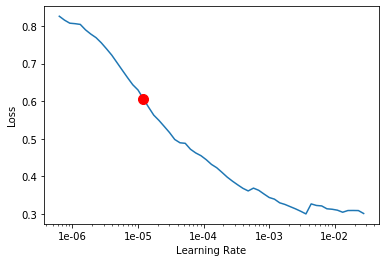

In [11]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [12]:
lr = 2e-3
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,dice,time
0,0.317263,0.278305,0.000000,00:07
1,0.254991,0.062973,0.004979,00:03
2,0.205554,0.060798,0.054842,00:03
3,0.162107,0.057476,0.420317,00:03
4,0.138524,0.050925,0.286593,00:03
5,0.120051,0.042866,0.485845,00:03
6,0.107324,0.036918,0.431935,00:03
7,0.096335,0.034956,0.483802,00:03
8,0.085105,0.036045,0.364462,00:03
9,0.078535,0.036743,0.306709,00:03


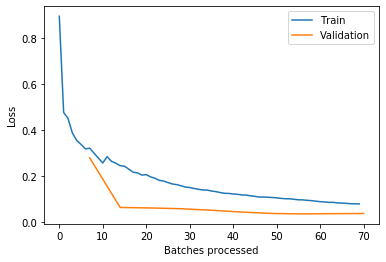

In [13]:
learn.recorder.plot_losses()

In [ ]:
# models_path = Path("../../models")
# learn.save(models_path/"2019-07-24_RESNET34_IOU0.66_stage1")

In [ ]:
# learn.load(models_path/"2019-07-24_RESNET34_IOU0.66_stage1");

In [14]:
learn.unfreeze()

In [15]:
lrs = slice(lr/400,lr/4)

In [16]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)
# learn.fit_one_cycle(12, lrs)

epoch,train_loss,valid_loss,dice,time
0,0.043141,0.034359,0.464004,00:05
1,0.045799,0.033974,0.458611,00:03
2,0.046375,0.033136,0.484616,00:03
3,0.047273,0.035393,0.530660,00:03
4,0.047037,0.034938,0.374438,00:03
5,0.046413,0.033522,0.264288,00:03
6,0.045535,0.032666,0.453593,00:03
7,0.043949,0.037236,0.486781,00:03
8,0.043561,0.031338,0.494243,00:03
9,0.041727,0.031521,0.532501,00:05


In [ ]:
# learn.save(models_path/"2019-07-24_RESNET34_IOU0.69_stage2")

In [ ]:
# learn.export(file = "../models/2019-07-24_RESNET34_IOU0.69_stage2.pkl")

## Check

In [ ]:
print(learn.data.valid_ds.__len__()) #list of N
print(learn.data.valid_ds[0]) #tuple of input image and segment
print(learn.data.valid_ds[0][1])
# print(learn.data.valid_ds.__len__())
# type(learn.data.valid_ds[0][0])

In [17]:
# preds = learn.get_preds(with_loss=True)
preds = learn.get_preds()

In [ ]:
print(len(preds)) # tuple of list of probs and targets
print(preds[0].shape) #predictions
print(preds[0][0].shape) #probabilities for each label
print(learn.data.classes) #what is each label
print(preds[0][0][0].shape) #probabilities for label 0
# for i in range(0,N):
#     print(torch.max(preds[0][i][1]))

# Image(preds[1][0]).show()

In [18]:
if learn.data.valid_ds.__len__() == preds[1].shape[0]:
    N = learn.data.valid_ds.__len__()
else:
    raise ValueError()

xs = [learn.data.valid_ds[i][0] for i in range(N)]
ys = [learn.data.valid_ds[i][1] for i in range(N)]
p0s = [Image(preds[0][i][0]) for i in range(N)]
p1s = [Image(preds[0][i][1]) for i in range(N)]
argmax = [Image(preds[0][i].argmax(dim=0)) for i in range(N)]

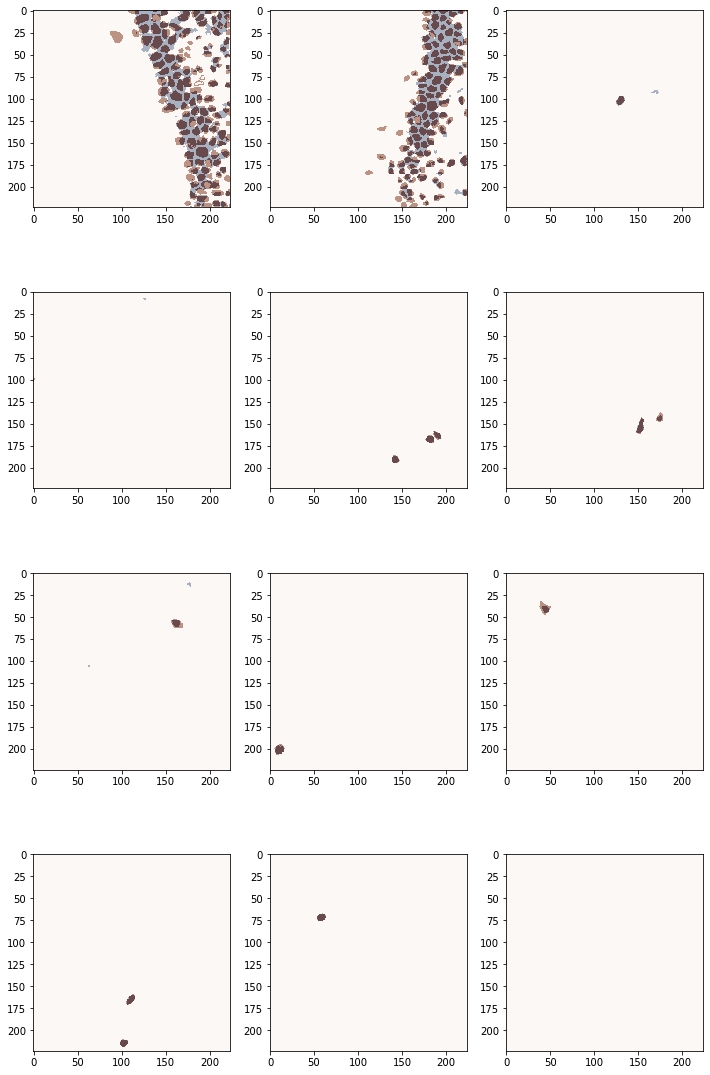

In [19]:
ncol = 3
nrow = N//ncol + 1
fig=plt.figure(figsize=(12, nrow*5))
for i in range(1,N):
    fig.add_subplot(nrow, ncol, i)
#     plt.imshow(xs[i-1].px.permute(1, 2, 0), cmap = "Oranges", alpha=0.5)
    plt.imshow(argmax[i-1].px, cmap = "Blues", alpha=0.7)
#     plt.imshow(p1s[i-1].px, cmap = "Blues", alpha=0.7)
    plt.imshow(ys[i-1].px[0], cmap = "Oranges", alpha=0.5)
# plt.savefig('/hpf/largeprojects/MICe/nwang/TissueVision/2019-05-31_Mallar_NeuralNet/figures/2019-06-12_mallar-results.png')
plt.show()

In [ ]:
#Wow resnet34 learns the same thing as resnet 50... I wish I did this earlier
!jupyter nbconvert arc-venus-train.ipynb --to html --output nbs/2019-07-24_RESNET34_IOU0.69_stage2.html